In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import os
from collections import defaultdict

In [2]:
CSV_FILENAME = "global_emissions.csv"
PARQUET_FILENAME = "global_emissions.parquet"
CHUNKSIZE = 1000

In [3]:
def benchmark_reading_speed():
    """Сравнивает скорость чтения CSV и Parquet файлов"""
    start_time = time.time()
    df_csv = pd.read_csv(CSV_FILENAME)
    csv_time = time.time() - start_time
    print(f"CSV: {csv_time:.3f} сек, {len(df_csv)} строк")
    
    start_time = time.time()
    df_parquet = pd.read_parquet(PARQUET_FILENAME)
    parquet_time = time.time() - start_time
    print(f"Parquet: {parquet_time:.3f} сек, {len(df_parquet)} строк")
    
    return csv_time, parquet_time

In [4]:
csv_time, parquet_time = benchmark_reading_speed()
print(f"Parquet быстрее в {csv_time/parquet_time:.1f} раз")

CSV: 0.013 сек, 2484 строк
Parquet: 0.039 сек, 2484 строк
Parquet быстрее в 0.3 раз


In [5]:
def read_csv_pandas_generator(filename, chunksize=1000):
    """Генератор для чтения CSV файла через Pandas"""
    for chunk in pd.read_csv(filename, chunksize=chunksize):
        yield chunk

In [ ]:
a = read_csv_pandas_generator(***)


In [6]:
def task1_get_data(chunk):
    valid_chunk = chunk[chunk['Country.Population'] > 0].copy()
    if len(valid_chunk) > 0:
        valid_chunk['per_capita'] = (
            valid_chunk['Emissions.Production.CO2.Total'] / 
            valid_chunk['Country.Population']
        )
    return valid_chunk

In [7]:
def task1_aggregation(aggregated):
    aggregated = aggregated.groupby('Country.Name')['per_capita'].mean().reset_index()
    
    sorted_data = aggregated.sort_values('per_capita')
    greenest = list(sorted_data.head(3).itertuples(index=False, name=None))
    dirtiest = list(sorted_data.tail(3).itertuples(index=False, name=None))
    return greenest, dirtiest

In [8]:
def task1_pipeline():
    """Задание 1: 3 самые 'зеленые' и 3 самые 'грязные' страны по выбросам на душу населения"""
    aggregated = pd.DataFrame()
    
    for chunk in read_csv_pandas_generator(CSV_FILENAME):
        valid_chunk = task1_get_data(chunk)
        aggregated = pd.concat([aggregated, valid_chunk[['Country.Name', 'per_capita']]], ignore_index=True)
    
    result = task1_aggregation(aggregated)
    return result


In [9]:
def task2_get_data(chunk):
    return chunk[['Country.Name', 'Emissions.Production.CO2.Total']]

In [10]:
def task2_aggregation(aggregated):
    country_std = aggregated.groupby('Country.Name')['Emissions.Production.CO2.Total'].std().reset_index()
    country_std = country_std.dropna()
    
    sorted_std = country_std.sort_values('Emissions.Production.CO2.Total')
    
    lowest_var = list(sorted_std.head(3).itertuples(index=False, name=None))
    highest_var = list(sorted_std.tail(3).itertuples(index=False, name=None))
    
    selected_countries = [country for country, _ in lowest_var + highest_var]
    ci_data = {}
    
    for country in selected_countries:
        country_data = aggregated[aggregated['Country.Name'] == country]['Emissions.Production.CO2.Total']
        if len(country_data) > 1:
            mean = country_data.mean()
            sem = country_data.std(ddof=1) / np.sqrt(len(country_data))
            ci = norm.ppf(0.95) * sem
            ci_data[country] = (mean - ci, mean + ci)
        else:
            ci_data[country] = (country_data.iloc[0], country_data.iloc[0])
    
    return lowest_var, highest_var, ci_data

In [11]:
def task2_pipeline():
    """Задание 2: Страны с наименьшим и наибольшим разбросом выбросов с доверительными интервалами"""
    aggregated = pd.DataFrame()
    
    for chunk in read_csv_pandas_generator(CSV_FILENAME):
        chunk_data = task2_get_data(chunk)
        aggregated = pd.concat([aggregated, chunk_data], ignore_index=True)
    
    result = task2_aggregation(aggregated)
    
    return result

In [12]:
def task3_get_data(chunk):
    chunk_agg = chunk.groupby('Year').agg({
            'Country.GDP': 'sum',
            'Emissions.Production.CO2.Total': 'sum'
        }).reset_index()
    return chunk_agg

In [13]:
def task3_aggregation(aggregated, chunk_agg):
    temp_df = chunk_agg.set_index('Year')
    temp_df.columns = ['gdp', 'emissions']
    
    aggregated = aggregated.add(temp_df, fill_value=0)
    return aggregated

In [14]:
def task3_pipeline():
    """Задание 3: Динамика ВВП и выбросов по годам"""
    aggregated = pd.DataFrame()
    
    for chunk in read_csv_pandas_generator(CSV_FILENAME):
        chunk_agg = task3_get_data(chunk)
        aggregated = task3_aggregation(aggregated, chunk_agg)

    result = []
    for year in sorted(aggregated.index):
        result.append((year, aggregated.loc[year, 'gdp'], aggregated.loc[year, 'emissions']))
    
    return result

In [15]:
def task4_parquet_pipeline():
    """Доп. задание 4: Корреляция между населением и выбросами (используя Parquet)"""
    df = pd.read_parquet(PARQUET_FILENAME, columns=['Country.Population', 'Emissions.Production.CO2.Total'])
    
    mask = (df['Country.Population'] > 0) & (df['Emissions.Production.CO2.Total'] > 0)
    df_clean = df[mask].dropna()
    
    populations = df_clean['Country.Population'].tolist()
    emissions = df_clean['Emissions.Production.CO2.Total'].tolist()
    correlation = df_clean['Country.Population'].corr(df_clean['Emissions.Production.CO2.Total'])
    
    return populations, emissions, correlation

In [16]:
def plot_results(task1_results, task2_results, task3_results, task4_results):
    """Строит все графики результатов"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    greenest, dirtiest = task1_results
    all_countries = greenest + dirtiest
    countries = [x[0] for x in all_countries]
    emissions_per_capita = [x[1] for x in all_countries]
    
    ax1.bar(countries, emissions_per_capita, color=['green']*3 + ['red']*3, alpha=0.7)
    ax1.set_title('Задание 1: Самые "зеленые" и "грязные" страны\n(выбросы на душу населения)', fontsize=12)
    ax1.set_yscale("log")
    ax1.set_ylabel('Выбросы CO2 на душу населения')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    lowest_var, highest_var, ci_data = task2_results
    all_countries_task2 = [x[0] for x in lowest_var] + [x[0] for x in highest_var]
    
    means = [np.mean(ci_data[country]) for country in all_countries_task2]
    errors = [[means[i] - ci_data[country][0] for i, country in enumerate(all_countries_task2)], 
              [ci_data[country][1] - means[i] for i, country in enumerate(all_countries_task2)]]
    
    bars = ax2.bar(all_countries_task2, means, yerr=errors, capsize=5, 
                   color=['blue']*3 + ['orange']*3, alpha=0.7)
    ax2.set_title('Задание 2: Страны с наименьшим/наибольшим разбросом выбросов\n(95% доверительные интервалы)', fontsize=12)
    ax2.set_ylabel('Средние выбросы CO2')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")
    
    years_data = task3_results
    years = [x[0] for x in years_data]
    gdp_values = [x[1] for x in years_data]
    emissions_values = [x[2] for x in years_data]
    
    gdp_norm = (gdp_values - np.min(gdp_values)) / (np.max(gdp_values) - np.min(gdp_values))
    emissions_norm = (emissions_values - np.min(emissions_values)) / (np.max(emissions_values) - np.min(emissions_values))
    
    ax3.plot(years, gdp_norm, 'g-', marker='o', linewidth=2, label='Нормализованный ВВП')
    ax3.plot(years, emissions_norm, 'r-', marker='s', linewidth=2, label='Нормализованные выбросы')
    ax3.set_title('Задание 3: Динамика ВВП и выбросов CO2', fontsize=12)
    ax3.set_xlabel('Год')
    ax3.set_ylabel('Нормализованные значения')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    populations, emissions, correlation = task4_results
    ax4.scatter(populations, emissions, alpha=0.6, s=20, color='purple')
    ax4.set_title(f'Задание 4: Корреляция население-выбросы\n(r = {correlation:.3f})', fontsize=12)
    ax4.set_xlabel('Население страны')
    ax4.set_ylabel('Выбросы CO2')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Выполнение задания 1...
Самые 'зеленые' страны: [('Tanzania', 1.3263032486002633e-07), ('Afghanistan', 1.3591735657202883e-07), ('Myanmar', 2.4995055099789933e-07)]
Самые 'грязные' страны: [('United Arab Emirates', 2.5080029938773547e-05), ('Kuwait', 2.763401588200854e-05), ('Qatar', 5.095651405186983e-05)]

Выполнение задания 2...


Страны с наименьшим разбросом: [('Gabon', 0.3542915325385154), ('Iceland', 0.4778637827580101), ('Cyprus', 0.8723678799386865)]
Страны с наибольшим разбросом: [('United States', 314.52700644984645), ('India', 608.486705535536), ('China', 2873.91034141179)]

Выполнение задания 3...

Выполнение доп. задания 4 с Parquet...
Корреляция: 0.702


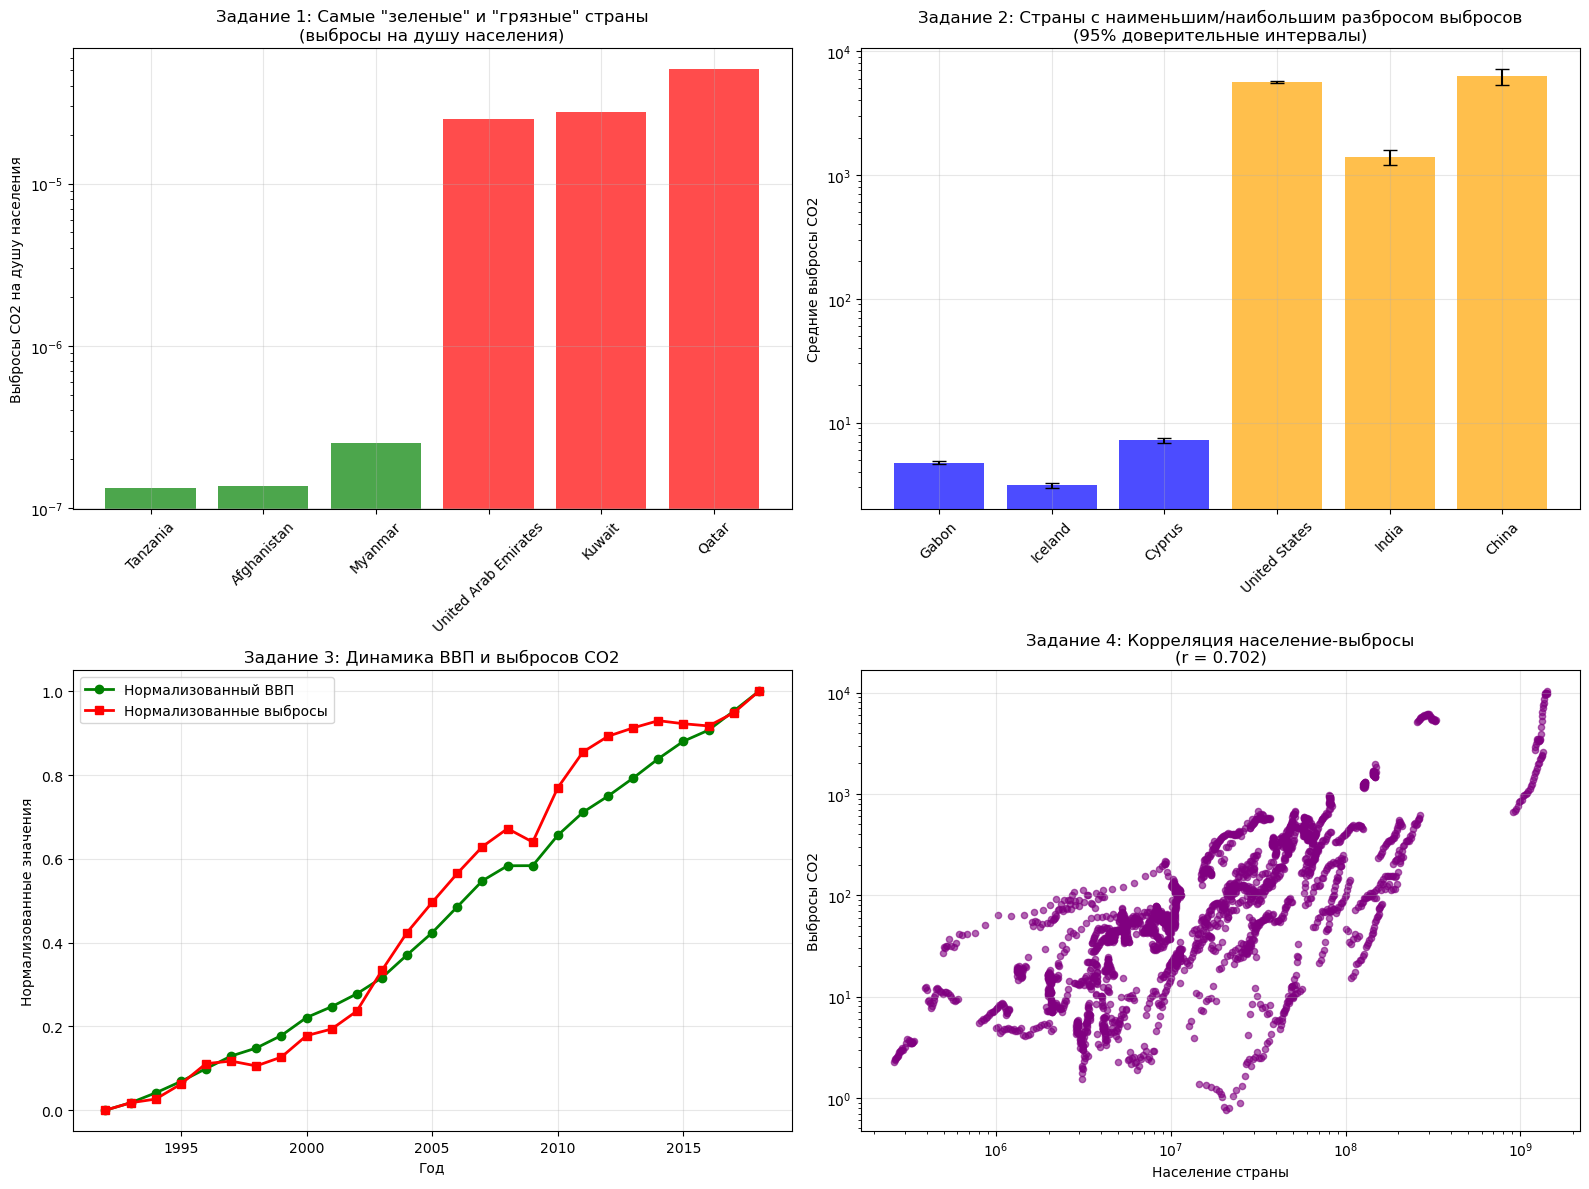

In [17]:
print("\nВыполнение задания 1...")
task1_results = task1_pipeline()
print("Самые 'зеленые' страны:", task1_results[0])
print("Самые 'грязные' страны:", task1_results[1])

print("\nВыполнение задания 2...")
task2_results = task2_pipeline()
print("Страны с наименьшим разбросом:", task2_results[0])
print("Страны с наибольшим разбросом:", task2_results[1])

print("\nВыполнение задания 3...")
task3_results = task3_pipeline()

print("\nВыполнение доп. задания 4 с Parquet...")
task4_results = task4_parquet_pipeline()
print(f"Корреляция: {task4_results[2]:.3f}")

plot_results(task1_results, task2_results, task3_results, task4_results)